In [1]:
# Reddit Dataset Quality Control Report
# Analyzes gold layer submissions and comments for Sep-Oct 2016

import sys
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

workspace_root = Path.cwd()
while not (workspace_root / '.git').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Reddit QC report started: {datetime.now().isoformat()}")
print(f"Workspace: {workspace_root}")

Reddit QC report started: 2025-12-21T09:08:07.382627
Workspace: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment


## 1. Setup Paths and Load Configuration

In [2]:
# Data directories
gold_submissions_dir = workspace_root / 'data/01_corpus/02_gold/reddit/submissions'
gold_comments_dir = workspace_root / 'data/01_corpus/02_gold/reddit/comments'

# Report output directory
report_dir = workspace_root / 'reports/data_validation/2016-09_2016-10/reddit'
figures_dir = report_dir / 'figures'
tables_dir = report_dir / 'tables'

# Create directories
report_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(exist_ok=True)
tables_dir.mkdir(exist_ok=True)

print(f"Gold submissions: {gold_submissions_dir.relative_to(workspace_root)}")
print(f"Gold comments: {gold_comments_dir.relative_to(workspace_root)}")
print(f"Report output: {report_dir.relative_to(workspace_root)}")

Gold submissions: data/01_corpus/02_gold/reddit/submissions
Gold comments: data/01_corpus/02_gold/reddit/comments
Report output: reports/data_validation/2016-09_2016-10/reddit


## 2. Load Monthly Data

Load submissions and comments from both months.

In [3]:
months = ['2016-09', '2016-10']

# Load submissions
submissions_dfs = []
for month in months:
    df = pd.read_parquet(gold_submissions_dir / f'{month}.parquet')
    submissions_dfs.append(df)

df_submissions = pd.concat(submissions_dfs, ignore_index=True)

# Load comments
comments_dfs = []
for month in months:
    df = pd.read_parquet(gold_comments_dir / f'{month}.parquet')
    comments_dfs.append(df)

df_comments = pd.concat(comments_dfs, ignore_index=True)

print(f"Submissions: {len(df_submissions):,}")
print(f"  Columns: {list(df_submissions.columns)}")
print(f"\nComments: {len(df_comments):,}")
print(f"  Columns: {list(df_comments.columns)}")
print(f"\nUnique submission_ids in submissions: {df_submissions['submission_id'].nunique():,}")
print(f"Unique submission_ids in comments: {df_comments['submission_id'].nunique():,}")
print(f"Unique subreddits: {df_submissions['subreddit'].nunique():,}")

Submissions: 923,431
  Columns: ['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id', 'subreddit', 'num_comments']

Comments: 8,698,923
  Columns: ['comment_id', 'submission_id', 'parent_id', 'created_utc', 'subreddit_id', 'subreddit', 'body']

Unique submission_ids in submissions: 923,431
Unique submission_ids in comments: 501,969
Unique subreddits: 368


## 3. Temporal Coverage Analysis

Analyze daily distributions of submissions and comments.

In [4]:
# Convert timestamps to dates
df_submissions['date'] = pd.to_datetime(df_submissions['created_utc'], unit='s').dt.date
df_comments['date'] = pd.to_datetime(df_comments['created_utc'], unit='s').dt.date

# Daily statistics for submissions
daily_subs = df_submissions.groupby('date').agg({
    'submission_id': 'count',
    'subreddit': 'nunique',
    'title': lambda x: x.str.len().mean(),
    'selftext': lambda x: x.str.len().mean(),
    'num_comments': 'sum'
}).rename(columns={
    'submission_id': 'submissions',
    'subreddit': 'unique_subreddits',
    'title': 'avg_title_length',
    'selftext': 'avg_selftext_length',
    'num_comments': 'total_comments_announced'
}).reset_index()

# Daily statistics for comments
daily_coms = df_comments.groupby('date').agg({
    'comment_id': 'count',
    'submission_id': 'nunique',
    'body': lambda x: x.str.len().mean()
}).rename(columns={
    'comment_id': 'comments',
    'submission_id': 'threads_with_comments',
    'body': 'avg_comment_length'
}).reset_index()

# Merge
df_daily = pd.merge(daily_subs, daily_coms, on='date', how='outer')
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values('date')

print("Daily statistics summary:")
print(df_daily.describe())
print("\n" + "=" * 80)

Daily statistics summary:
                      date   submissions  unique_subreddits  avg_title_length  \
count                   61     61.000000          61.000000         61.000000   
mean   2016-10-01 00:00:00  15138.213115         246.950820         74.731874   
min    2016-09-01 00:00:00   7880.000000         227.000000         68.079815   
25%    2016-09-16 00:00:00  12587.000000         240.000000         73.570839   
50%    2016-10-01 00:00:00  14381.000000         248.000000         74.415989   
75%    2016-10-16 00:00:00  17150.000000         254.000000         76.593642   
max    2016-10-31 00:00:00  25837.000000         262.000000         78.843892   
std                    NaN   4023.212573           9.241981          2.193509   

       avg_selftext_length  total_comments_announced       comments  \
count            61.000000                 61.000000      61.000000   
mean             64.169322             151657.442623  142605.295082   
min              48.084762     

## 4. Plot: Submissions and Comments per Day

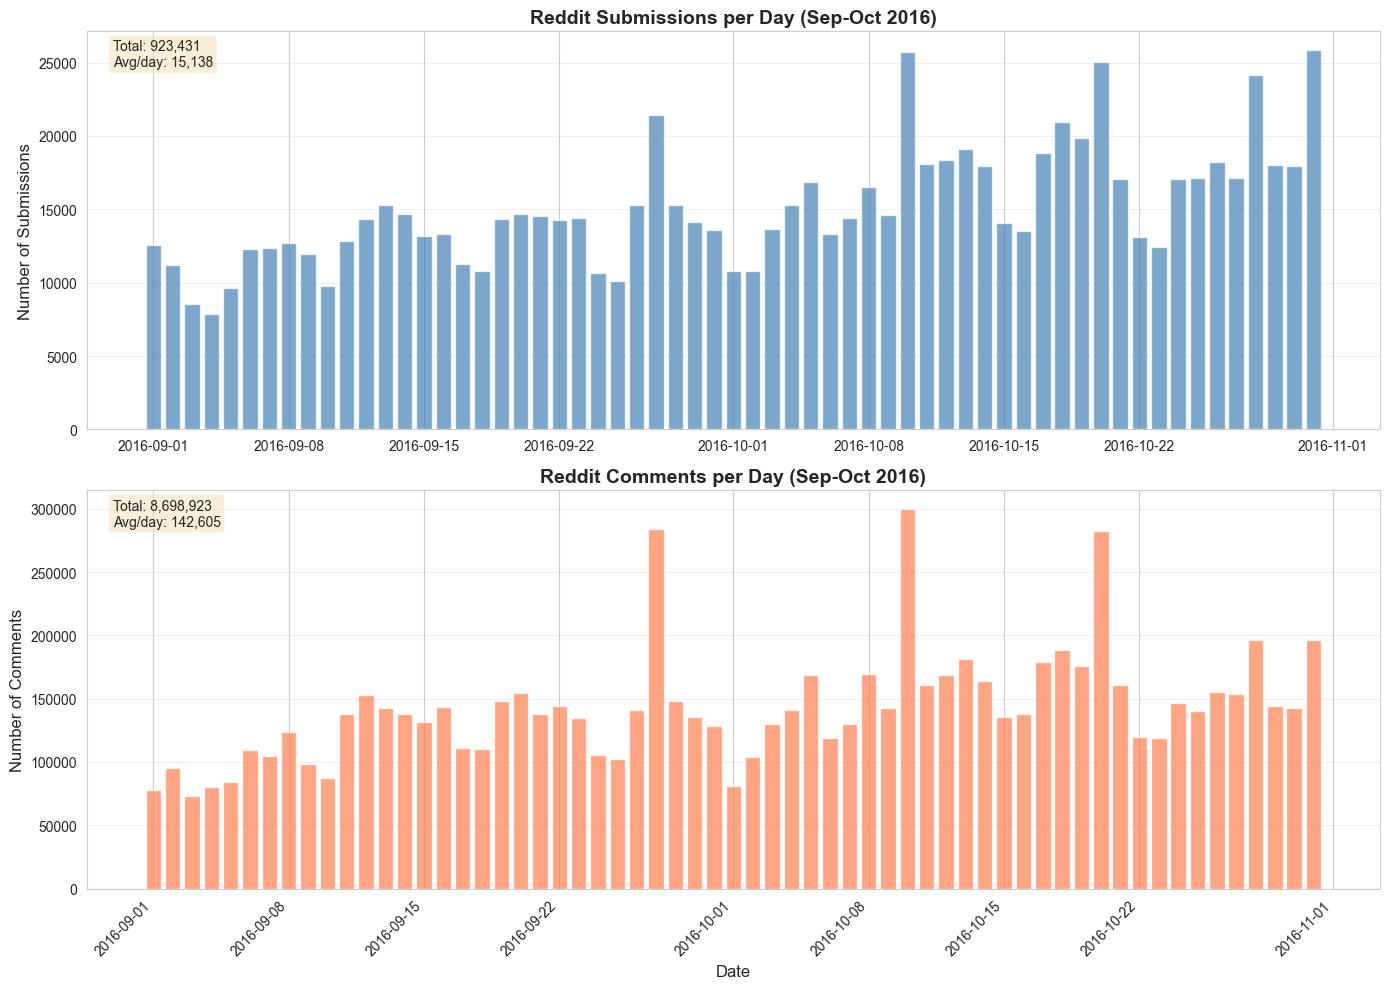

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/submissions_comments_per_day.png


In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Submissions
ax1.bar(df_daily['date'], df_daily['submissions'], color='steelblue', alpha=0.7)
ax1.set_ylabel('Number of Submissions', fontsize=12)
ax1.set_title('Reddit Submissions per Day (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

total_subs = df_daily['submissions'].sum()
avg_subs = df_daily['submissions'].mean()
ax1.text(0.02, 0.98, f'Total: {total_subs:,.0f}\nAvg/day: {avg_subs:,.0f}', 
        transform=ax1.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Comments
ax2.bar(df_daily['date'], df_daily['comments'], color='coral', alpha=0.7)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Number of Comments', fontsize=12)
ax2.set_title('Reddit Comments per Day (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

total_coms = df_daily['comments'].sum()
avg_coms = df_daily['comments'].mean()
ax2.text(0.02, 0.98, f'Total: {total_coms:,.0f}\nAvg/day: {avg_coms:,.0f}', 
        transform=ax2.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(figures_dir / 'submissions_comments_per_day.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {(figures_dir / 'submissions_comments_per_day.png').relative_to(workspace_root)}")

## 5. Submission-Comment Linkage Analysis

Verify that comments properly link to submissions.

Submission-Comment Linkage:
Total submissions: 923,431
Submissions referenced in comments: 501,969
Successfully matched: 501,969 (100.00%)
Orphaned (comments without submission): 0

Comments per submission statistics:
count    501969.000000
mean         17.329602
std         155.921138
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max       24157.000000
dtype: float64


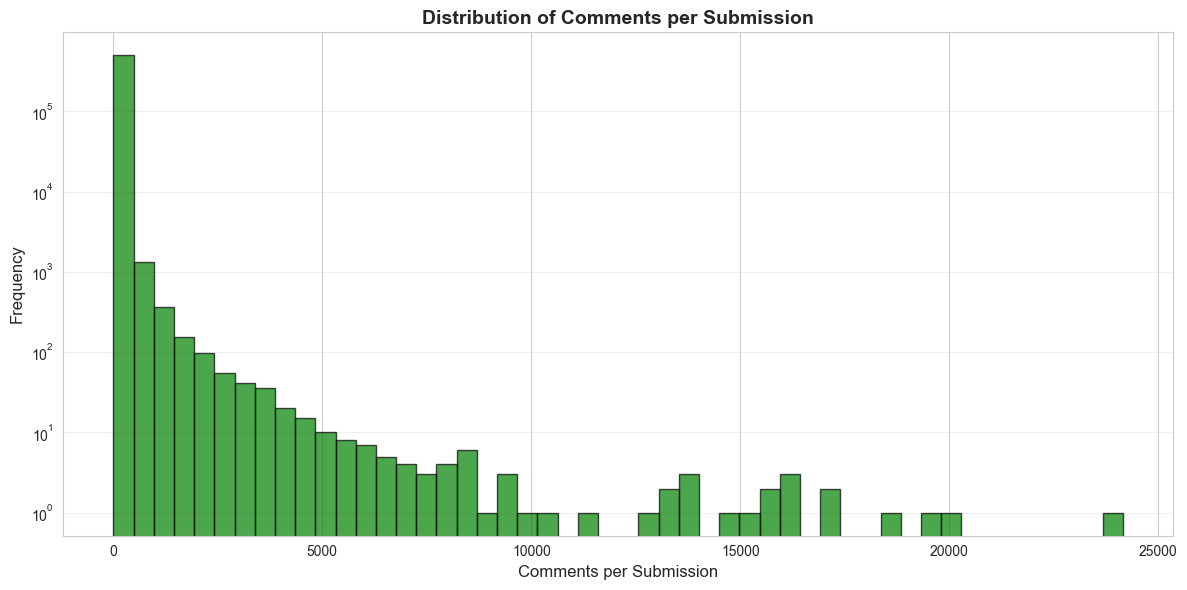


✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/comments_per_submission_dist.png


In [6]:
# Check linkage
submission_ids_from_subs = set(df_submissions['submission_id'])
submission_ids_from_coms = set(df_comments['submission_id'])

matched = len(submission_ids_from_coms & submission_ids_from_subs)
orphaned = len(submission_ids_from_coms - submission_ids_from_subs)

print("Submission-Comment Linkage:")
print("=" * 80)
print(f"Total submissions: {len(df_submissions):,}")
print(f"Submissions referenced in comments: {len(submission_ids_from_coms):,}")
print(f"Successfully matched: {matched:,} ({100*matched/len(submission_ids_from_coms):.2f}%)")
print(f"Orphaned (comments without submission): {orphaned:,}")

# Comments per submission distribution
comments_per_sub = df_comments.groupby('submission_id').size()
print(f"\nComments per submission statistics:")
print(comments_per_sub.describe())

# Plot distribution
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(comments_per_sub, bins=50, color='green', alpha=0.7, edgecolor='black')
ax.set_xlabel('Comments per Submission', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Comments per Submission', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'comments_per_submission_dist.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {(figures_dir / 'comments_per_submission_dist.png').relative_to(workspace_root)}")

## 6. Subreddit Distribution Analysis

In [7]:
# Subreddit distribution for submissions
subreddit_subs = df_submissions['subreddit'].value_counts()
print(f"Total unique subreddits: {len(subreddit_subs)}")
print(f"\nTop 20 subreddits by submission count:")
print(subreddit_subs.head(20))

# Subreddit distribution for comments
subreddit_coms = df_comments['subreddit'].value_counts()
print(f"\nTop 20 subreddits by comment count:")
print(subreddit_coms.head(20))

# Combined view
df_subreddit_stats = pd.DataFrame({
    'submissions': subreddit_subs,
    'comments': subreddit_coms
}).fillna(0).astype(int)
df_subreddit_stats['total_activity'] = df_subreddit_stats['submissions'] + df_subreddit_stats['comments']
df_subreddit_stats = df_subreddit_stats.sort_values('total_activity', ascending=False)

print(f"\nTop 20 subreddits by total activity:")
print(df_subreddit_stats.head(20))

Total unique subreddits: 368

Top 20 subreddits by submission count:
subreddit
The_Donald          372577
politics             81629
BreakingNews24hr     43418
ImABlue              27836
EnoughTrumpSpam      27134
willis7737_news      22958
TheColorIsBlue       22701
hillaryclinton       20967
NoFilterNews         14780
HillaryForPrison     13809
syriancivilwar       12609
TheColorIsRed        11340
AutoNewspaper         8342
ukpolitics            6725
GaryJohnson           6673
uncensorednews        6142
worldpolitics         6141
Conservative          6126
PoliticalVideo        6087
WayOfTheBern          5823
Name: count, dtype: int64

Top 20 subreddits by comment count:
subreddit
politics                3652279
The_Donald              2284129
hillaryclinton           315427
EnoughTrumpSpam          280239
PoliticalDiscussion      263713
ukpolitics               216811
syriancivilwar           126726
WayOfTheBern              70670
AskTrumpSupporters        66247
GaryJohnson         

## 7. Plot: Top Subreddits by Activity

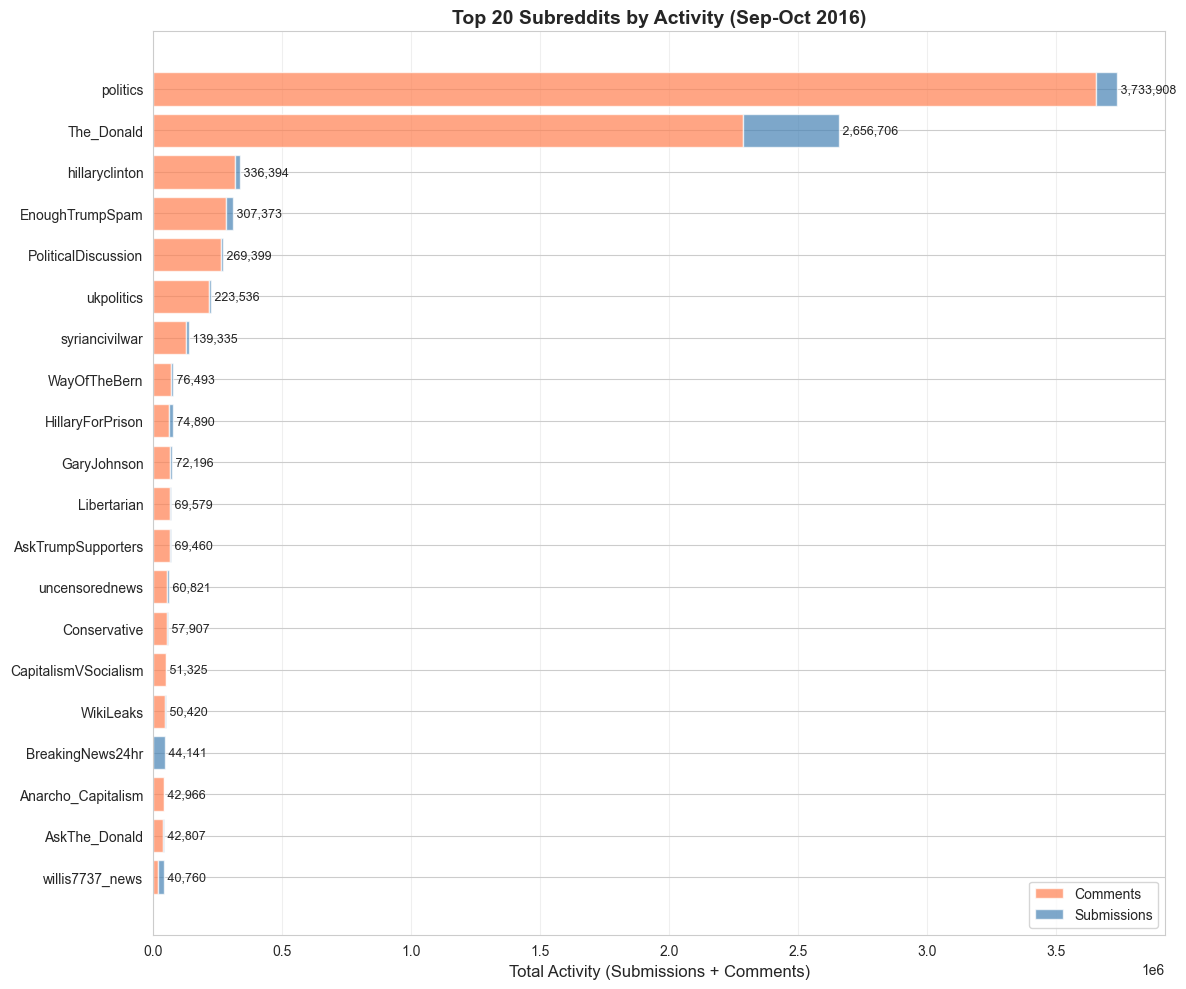

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/top_subreddits_activity.png


In [8]:
fig, ax = plt.subplots(figsize=(12, 10))

top_20 = df_subreddit_stats.head(20)
y_pos = range(len(top_20))

ax.barh(y_pos, top_20['comments'], label='Comments', color='coral', alpha=0.7)
ax.barh(y_pos, top_20['submissions'], left=top_20['comments'], 
        label='Submissions', color='steelblue', alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_20.index)
ax.set_xlabel('Total Activity (Submissions + Comments)', fontsize=12)
ax.set_title('Top 20 Subreddits by Activity (Sep-Oct 2016)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add total labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    total = row['total_activity']
    ax.text(total, i, f' {total:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(figures_dir / 'top_subreddits_activity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {(figures_dir / 'top_subreddits_activity.png').relative_to(workspace_root)}")

## 8. Text Length Analysis

Text Length Statistics:

Submission Titles:
count    923431.000000
mean         74.759224
std          45.470787
min           1.000000
25%          47.000000
50%          65.000000
75%          90.000000
max         327.000000
Name: title_length, dtype: float64

Submission Selftext:
count    923431.000000
mean         63.909423
std         510.053949
min           0.000000
25%           0.000000
50%           0.000000
75%           9.000000
max       40000.000000
Name: selftext_length, dtype: float64

Comment Body:
count    8.698923e+06
mean     2.204189e+02
std      3.815692e+02
min      1.000000e+01
25%      5.300000e+01
50%      1.100000e+02
75%      2.360000e+02
max      1.202200e+04
Name: body_length, dtype: float64


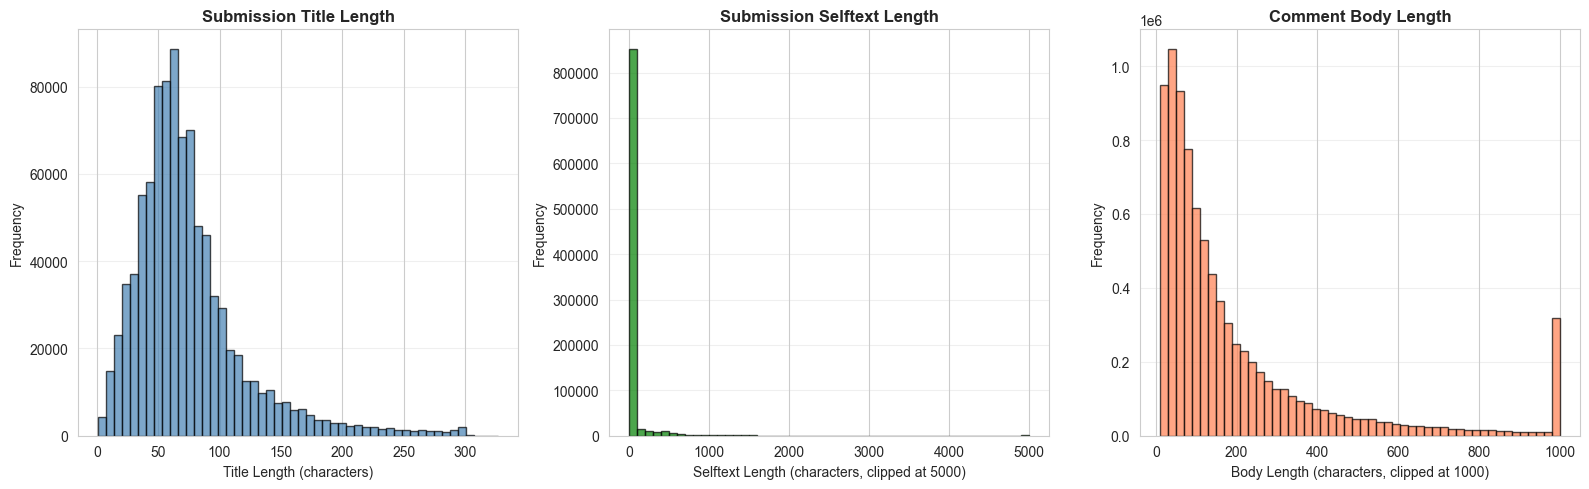


✓ Saved: reports/data_validation/2016-09_2016-10/reddit/figures/text_length_distributions.png


In [11]:
# Analyze text lengths
df_submissions['title_length'] = df_submissions['title'].str.len()
df_submissions['selftext_length'] = df_submissions['selftext'].str.len()
df_comments['body_length'] = df_comments['body'].str.len()

print("Text Length Statistics:")
print("=" * 80)
print("\nSubmission Titles:")
print(df_submissions['title_length'].describe())
print("\nSubmission Selftext:")
print(df_submissions['selftext_length'].describe())
print("\nComment Body:")
print(df_comments['body_length'].describe())

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(df_submissions['title_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Title Length (characters)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title('Submission Title Length', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(df_submissions['selftext_length'].clip(upper=5000), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Selftext Length (characters, clipped at 5000)', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].set_title('Submission Selftext Length', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

axes[2].hist(df_comments['body_length'].clip(upper=1000), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Body Length (characters, clipped at 1000)', fontsize=10)
axes[2].set_ylabel('Frequency', fontsize=10)
axes[2].set_title('Comment Body Length', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'text_length_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {(figures_dir / 'text_length_distributions.png').relative_to(workspace_root)}")

## 9. Save Summary Tables

In [12]:
# Save daily statistics
df_daily_export = df_daily.copy()
df_daily_export['date'] = df_daily_export['date'].dt.strftime('%Y-%m-%d')
df_daily_export.to_csv(tables_dir / 'daily_statistics.csv', index=False)
print(f"✓ Saved: {(tables_dir / 'daily_statistics.csv').relative_to(workspace_root)}")

# Save subreddit statistics
df_subreddit_stats.head(50).to_csv(tables_dir / 'top_50_subreddits.csv')
print(f"✓ Saved: {(tables_dir / 'top_50_subreddits.csv').relative_to(workspace_root)}")

# Save overall summary
summary_stats = {
    'metric': [
        'Total Submissions',
        'Total Comments',
        'Unique Subreddits',
        'Unique Submission IDs (from submissions)',
        'Unique Submission IDs (from comments)',
        'Orphaned Comments',
        'Date Range',
        'Days Covered',
        'Avg Submissions/Day',
        'Avg Comments/Day'
    ],
    'value': [
        f"{len(df_submissions):,}",
        f"{len(df_comments):,}",
        f"{df_submissions['subreddit'].nunique():,}",
        f"{len(submission_ids_from_subs):,}",
        f"{len(submission_ids_from_coms):,}",
        f"{orphaned:,}",
        f"{df_daily['date'].min().strftime('%Y-%m-%d')} to {df_daily['date'].max().strftime('%Y-%m-%d')}",
        f"{len(df_daily)}",
        f"{df_daily['submissions'].mean():.0f}",
        f"{df_daily['comments'].mean():.0f}"
    ]
}

pd.DataFrame(summary_stats).to_csv(tables_dir / 'overall_summary.csv', index=False)
print(f"✓ Saved: {(tables_dir / 'overall_summary.csv').relative_to(workspace_root)}")
print("\n" + "=" * 80)
print("✓ QC Report Complete!")

✓ Saved: reports/data_validation/2016-09_2016-10/reddit/tables/daily_statistics.csv
✓ Saved: reports/data_validation/2016-09_2016-10/reddit/tables/top_50_subreddits.csv
✓ Saved: reports/data_validation/2016-09_2016-10/reddit/tables/overall_summary.csv

✓ QC Report Complete!
